# Part 1

**What did we learn last week?**: We got a first look at PyTorch and trained a deep learning model with automatic differentiation.

**What you will learn today**: We will take a closer look at Convolutional Neural Networks and understand why they are ubiquitously used. Then, we will look at the *correct* way of evaluating performance. Finally, we will explore some important hyperparameters/design decision for
boosting performance.

## Convolutional Neural Networks

Great sources:
- https://poloclub.github.io/cnn-explainer/
- https://setosa.io/ev/image-kernels/

![](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Why convolutions and not fully-connected layers?** In the previous lab, we used a MultiLayer Perceptron (MLP) to perform classification on the MNIST dataset of handwritten digits. However, MLPs expect a vector as an input and, hence, our first step was to *flatten* the image; from an input of shape $(1, 28, 28)$ we got a vector of $1\times28\times28=784$ elements. Then, each layer of the MLP is fully connected, meaning that all $784$ elements are fed into each neuron of the next layer.

Does this sound reasonable?

No! First, by flattening we implicitly lose *local* information. Assume you look at pixel in location $(5,5)$, then the neighboring pixels $(4,5),(6,5), (5,4), (5,6),\dots$ are important and must be "somewhat similar". Second, by using all elements of the previous layer. the top left and bottom right pixels are used in the same computation.

Convolutional Neural Networks address these (and more) concerns and are suitable for the image domain. But, what are convolutions? We start with a small matrix of weights, e.g. $3\times3$, which is called a kernel. The kernel is then slided over the 2d input and we perform elementwise multiplication with the values the kernel is currently on. The summation of the $3\times3=9$ elements is the output for the pixel. Hence, the kernel performs a "local" computation. *Back in the day*, kernels were hand-designed to perform a specific operation. For example, the Sobel operator is used for edge-detection:

$$
\mathbf{G}_x=\left[\begin{array}{ccc}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{array}\right] * \mathbf{A} \quad \text { and } \quad \mathbf{G}_y=\left[\begin{array}{ccc}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right] * \mathbf{A}
$$

$$
\mathbf{G}=\sqrt{\mathbf{G}_x^2+\mathbf{G}_y^2}
$$

For example:

![](https://miro.medium.com/max/640/1*m9XHMKQPY6mKYsaykuVAsw.webp)

Creating filters for every different scenario requires domain knowledge and is cumbersome. (Convolutional) Neural Networks learn the values of these filters in an "end-to-end" manner!

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# import our "local" library of functions
from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [22]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# for Mac users with M1 chip, use this line instead
#DEVICE = torch.device("mps")
print(DEVICE)

cuda


In [6]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 132105069.77it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 110828631.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42970793.55it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5379985.53it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



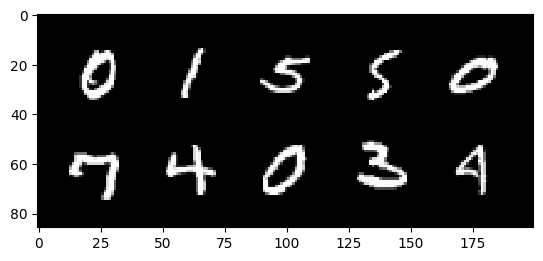

In [7]:
visualize_images(train_dataloader)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [ ]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=1.2579284704337685
Epoch 1: Loss=0.3849395670123019
Epoch 2: Loss=0.24089257848464837
Epoch 3: Loss=0.18991740376262342
Epoch 4: Loss=0.1568830131979312
Epoch 5: Loss=0.13781677009695667
Epoch 6: Loss=0.12170897411592936
Epoch 7: Loss=0.10986392111596414
Epoch 8: Loss=0.10245832295741066
Epoch 9: Loss=0.09448506683111191
Test set: Avg. loss: 0.0880, Accuracy: 9720/10000 (97%)


(0.08802287750244141, tensor(97.2000, device='mps:0'))

## CIFAR10

In [9]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 31055865.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


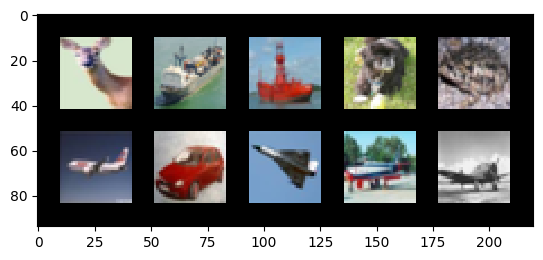

In [10]:
visualize_images(train_dataloader)

In [ ]:
class CifarCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3, #COLORED IMAGES!
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10) #Now is 32x32 images!

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

cnn_cifar = CifarCNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn_cifar.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn_cifar,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn_cifar, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=2.2464309419904436
Epoch 1: Loss=2.1687568596431186
Epoch 2: Loss=2.059944060384011
Epoch 3: Loss=1.9308553617827746
Epoch 4: Loss=1.8202597024489422
Epoch 5: Loss=1.7463843846807674
Epoch 6: Loss=1.664334774017334
Epoch 7: Loss=1.595800027555349
Epoch 8: Loss=1.5432776918216629
Epoch 9: Loss=1.5090045612685534
Test set: Avg. loss: 1.4457, Accuracy: 4969/10000 (50%)


(1.4456957763671876, tensor(49.6900, device='mps:0'))

**Takeaways**: CIfar10 is a more complex dataset than MNIST; the images are larger and RGB, the model is larger and a simple training scheme returns very bad results! How can we change this?

## Validation set

Before looking into tips and tricks for boosting the performance of a model, we need to establish a proper evaluation protocol. This is where the validation set comes in.

In the real world, we do not have access to the test set, e.g., customer churning or self-driving cars. But, still, we need to evaluate the performance of our models on *unseen data*. The most common way is to split the training set into training+validation.

In [11]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [12]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Modify the fit function to also use a validation set

In [13]:
from typing import Optional

def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

In [ ]:
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

Epoch 0: Train Loss=1.4707, Validation Loss=0.8609, Validation acc=73.5300
Epoch 1: Train Loss=0.4312, Validation Loss=0.3087, Validation acc=91.1300
Epoch 2: Train Loss=0.2665, Validation Loss=0.2326, Validation acc=93.3700
Epoch 3: Train Loss=0.2050, Validation Loss=0.2042, Validation acc=94.0200
Epoch 4: Train Loss=0.1725, Validation Loss=0.1764, Validation acc=94.6800
Epoch 5: Train Loss=0.1529, Validation Loss=0.1530, Validation acc=95.4600
Epoch 6: Train Loss=0.1368, Validation Loss=0.1409, Validation acc=95.7600
Epoch 7: Train Loss=0.1237, Validation Loss=0.1246, Validation acc=96.3900
Epoch 8: Train Loss=0.1145, Validation Loss=0.1179, Validation acc=96.6400
Epoch 9: Train Loss=0.1055, Validation Loss=0.1110, Validation acc=96.7600
Test set: Avg. loss: 0.0930, Accuracy: 9719/10000 (97%)


(0.0930219783782959, tensor(97.1900, device='cuda:0'))

## Importance of optimizer and learning rate

So far in this lab, we have used the same learning rate and optimizer (vanilla SGD). However, the choice of optimizer and the corresponding hyperparameters play a crucial role in the end performance.

Explore the exact same experiment as before BUT change the learning rate to $0.001$. How does this change affect performance?

Epoch 0: Train Loss=2.3010, Validation Loss=2.2993, Validation acc=13.1600
Epoch 1: Train Loss=2.2982, Validation Loss=2.2966, Validation acc=13.5500
Epoch 2: Train Loss=2.2955, Validation Loss=2.2939, Validation acc=13.9000
Epoch 3: Train Loss=2.2927, Validation Loss=2.2911, Validation acc=14.9700
Epoch 4: Train Loss=2.2900, Validation Loss=2.2883, Validation acc=16.7700
Epoch 5: Train Loss=2.2871, Validation Loss=2.2855, Validation acc=18.9400
Epoch 6: Train Loss=2.2842, Validation Loss=2.2825, Validation acc=21.6500
Epoch 7: Train Loss=2.2812, Validation Loss=2.2795, Validation acc=24.4000
Epoch 8: Train Loss=2.2782, Validation Loss=2.2764, Validation acc=27.4600
Epoch 9: Train Loss=2.2749, Validation Loss=2.2731, Validation acc=30.4800
Test set: Avg. loss: 2.2730, Accuracy: 3140/10000 (31%)


Text(0, 0.5, 'Train loss')

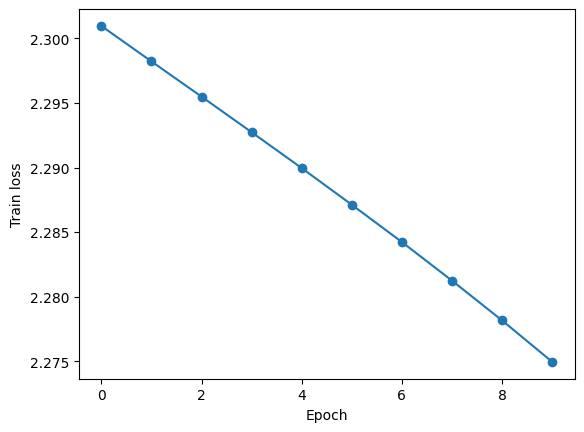

In [ ]:
cnn = CNN().to(DEVICE)

optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001)

train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

Now try with a higher learning rate ($\eta\geq0.5$), describe (qualitative) what happens. [0.5 points]

Epoch 0: Train Loss=2.6179, Validation Loss=2.3018, Validation acc=11.2900
Epoch 1: Train Loss=2.3017, Validation Loss=2.3010, Validation acc=11.2900
Epoch 2: Train Loss=2.3015, Validation Loss=2.3009, Validation acc=11.2900
Epoch 3: Train Loss=2.3015, Validation Loss=2.3009, Validation acc=11.2900
Epoch 4: Train Loss=2.3015, Validation Loss=2.3010, Validation acc=11.2900
Epoch 5: Train Loss=2.3015, Validation Loss=2.3012, Validation acc=11.2900
Epoch 6: Train Loss=2.3016, Validation Loss=2.3010, Validation acc=11.2900
Epoch 7: Train Loss=2.3015, Validation Loss=2.3012, Validation acc=11.2900
Epoch 8: Train Loss=2.3015, Validation Loss=2.3007, Validation acc=11.2900
Epoch 9: Train Loss=2.3016, Validation Loss=2.3007, Validation acc=11.2900
Test set: Avg. loss: 2.3011, Accuracy: 1135/10000 (11%)


Text(0, 0.5, 'Train loss')

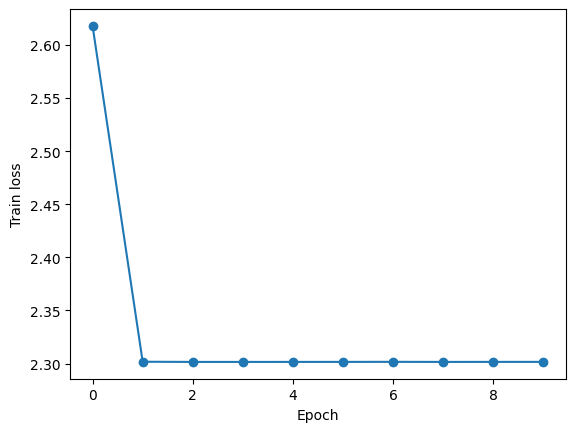

In [ ]:
cnn = CNN().to(DEVICE)

optimizer = torch.optim.SGD(cnn.parameters(), lr=1)

train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



Implement momentum and compute the learning curve [0.25 points]

Epoch 0: Train Loss=2.2949, Validation Loss=2.2805, Validation acc=18.8500
Epoch 1: Train Loss=2.2642, Validation Loss=2.2428, Validation acc=47.9800
Epoch 2: Train Loss=2.2127, Validation Loss=2.1707, Validation acc=60.3300
Epoch 3: Train Loss=2.1017, Validation Loss=2.0022, Validation acc=66.1600
Epoch 4: Train Loss=1.8313, Validation Loss=1.5983, Validation acc=71.3700
Epoch 5: Train Loss=1.3055, Validation Loss=1.0175, Validation acc=77.0000
Epoch 6: Train Loss=0.8356, Validation Loss=0.7036, Validation acc=81.5500
Epoch 7: Train Loss=0.6225, Validation Loss=0.5692, Validation acc=83.9500
Epoch 8: Train Loss=0.5230, Validation Loss=0.5004, Validation acc=85.7500
Epoch 9: Train Loss=0.4668, Validation Loss=0.4563, Validation acc=87.0200
Test set: Avg. loss: 0.4298, Accuracy: 8791/10000 (88%)


Text(0, 0.5, 'Train loss')

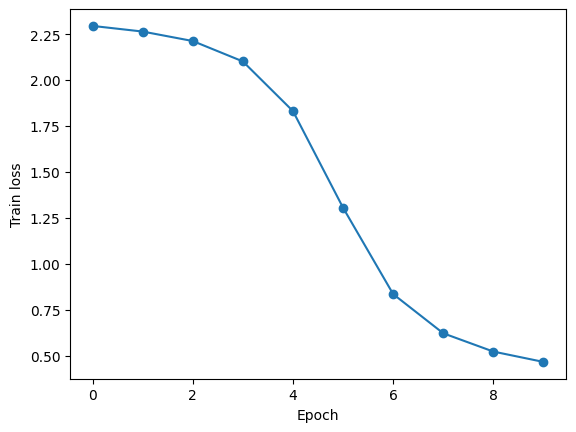

In [ ]:
cnn = CNN().to(DEVICE)

optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

## Hyperparameters: Learning rate and batch size [1 point]

While intution can help us select the settings of an experiment, the choice becomes complicated when more and more hyperparameters need to be taken account. Just to name a few, we might want to select learning rate, momentum or optimizer, batch size, number of layers, width of layers etc

Hence, we need a systematic way to approach this problem. The most simple way is to perfrom a grid search; define a list of choices for each hyperparameter and search over all combinations.

In [ ]:
# Perform a grid search over 2 values of learning rate and 2 values of Batch size.

from itertools import product

LR_GRID = [0.01, 0.1]
BS_GRID = [256, 512]


grid = list(product(LR_GRID, BS_GRID))

models = {}
for index, (lr, bs) in enumerate(grid):

    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=bs,
        shuffle=True,
        num_workers=2)

    cnn = CNN().to(DEVICE)

    optimizer = torch.optim.SGD(cnn.parameters(), lr=lr)

    train_losses, valid_losses, valid_accs = fit(
        model=cnn,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer,
        epochs=10,
        device=DEVICE
    )

    print(f"%"*100)
    print(f"Trial {index}[lr={lr}, bs={bs}]: Validation accuracy = {valid_accs[-1]:.4f}")
    print(f"%"*100)

    models[index] = cnn

Epoch 0: Train Loss=1.9769, Validation Loss=1.1354, Validation acc=75.8100
Epoch 1: Train Loss=0.6563, Validation Loss=0.4896, Validation acc=85.6400
Epoch 2: Train Loss=0.4195, Validation Loss=0.4081, Validation acc=87.7100
Epoch 3: Train Loss=0.3585, Validation Loss=0.3696, Validation acc=88.7400
Epoch 4: Train Loss=0.3251, Validation Loss=0.3637, Validation acc=89.0800
Epoch 5: Train Loss=0.3011, Validation Loss=0.3419, Validation acc=89.6800
Epoch 6: Train Loss=0.2788, Validation Loss=0.3102, Validation acc=91.0300
Epoch 7: Train Loss=0.2614, Validation Loss=0.2711, Validation acc=91.6800
Epoch 8: Train Loss=0.2425, Validation Loss=0.2434, Validation acc=92.9700
Epoch 9: Train Loss=0.2288, Validation Loss=0.2403, Validation acc=93.1400
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Trial 0[lr=0.01, bs=256]: Validation accuracy = 93.1400
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [ ]:
# Evaluate the performance on the test set with the best model!
predict(model=models[3], test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0609, Accuracy: 9808/10000 (98%)


(0.06094037036895752, tensor(98.0800, device='cuda:0'))

# Part 2

On the previous part we implemented CNNs using the `PyTorch` library. Our experiments showed that for image classification a CNN architecture yields good results on MNIST and, depending on the complexity of the network you created, "good" results on CIFAR10. However, dealing with MNIST someone might have gotten the wrong impression: "everythings work out-of-the-box or like magic in Deep Learning". Reality is not so rosy and we must go to great lengths do replicate our success on MNIST for other datasets.

In this part, we will explore common pitfalls as well as common tips and tricks to resolve them. These simple methods will provide superior performance and are very easy to incorporate in our pipeline.

Specifically, we will talk about:
- Batch Normalization
- Learning rate scheduler
- Residual Connections

So... let's get started!


In [14]:
# first we load all the necessary libraries

import torchvision.transforms as transforms
import torch.nn.functional as F

In [15]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [16]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)


## Batch normalization

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. Why does BatchNorm actually do?
    * Suppose we are given values of $x=1$

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. Why does BatchNorm actually do?

Suppose we are given values of $x$ over a mini-batch $B=\{x_i\}_{i=1}^m$. Our goal is to learn some parameters $\gamma$ and $\beta$ that perform the proper scaling.

- First, we compute the mini-batch mean
    $$
    \mu_{B}=\frac{1}{m}\sum_{i=1}^mx_i
    $$
and mini-batch variance
    $$
    \sigma^2_{B}=\frac{1}{m}\sum_{i=1}^m (x_i-\mu_{B})^2
    $$
- we use these quantities to normalize our input
    $$
    x_i\leftarrow\frac{x_i-\mu_{B}}{\sqrt{\sigma^2_{B}+\epsilon}}
    $$
- We scale, shift and return the output
    $$
    y_i=\gamma x_i+\beta\equiv \text{BN}_{\gamma, \beta}(x_i)
    $$
Essentially, for each mini-batch we normalize the inputs by subtracting their mean and dividing by their standard deviation (estimated based on the statistics of the current mini-batch)  


3. Why does BatchNorm work?

    * BatchNorm is widely used (e.g. the original paper [1] has over 50000 citations). However, the reasons of its success are not perfectly clear.
    * The original authors claim that BatchNorm helps alleviate *Internal Covariate shift*, i.e. the phenomenon of shifting input distributions. Specifically, the input to each layer can be seen as a data distribution that the layer is trying to “learn”. The model, though, does not see the whole dataset but simply mini-batches. If this distribution stays consistent across batches, the layer can "learn effectively".  But, does this happen in practice?
    * the reality is that different mini-batches have different statistics, e.g. mean, variance etc, making the input distribution to the layers jump around. In other words, the input distribuion shifts for every mini-batch. We are trying to learn a "moving target". What if we stabilize it?
    * Batch normalization keeps the input normalized (duh!), preventing them from becoming too large or small and keeping the distribution consistent.
    
    * It also directly placates the exploding/vanishing gradient problem and  allows higher learning rates.

    * However, other explanations have been proposed. [2] claims that BatchNorm "makes the optimization landscape significantly smoother. This smoothness induces a more predictive and stable behavior of the gradients, allowing for faster training".


---
[1] S. Ioffe and C. Szegedy, “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift,” in Proceedings of the 32nd International Conference on Machine Learning, Jun. 2015, pp. 448–456. Accessed: Oct. 25, 2021. [Online]. Available: https://proceedings.mlr.press/v37/ioffe15.html

[2] S. Santurkar, D. Tsipras, A. Ilyas, and A. Madry, “How Does Batch Normalization Help Optimization?,” in Advances in Neural Information Processing Systems, 2018, vol. 31. Accessed: Oct. 25, 2021. [Online]. Available: https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html



Redo the previous cnn architecture with batch normalization.
Where does the batch normalization go? [0.25 points]

In [17]:
class CNNwithBN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

Epoch 0: Train Loss=1.5470
Epoch 1: Train Loss=1.1724
Epoch 2: Train Loss=1.0530
Epoch 3: Train Loss=0.9637
Epoch 4: Train Loss=0.9046
Epoch 5: Train Loss=0.8703
Epoch 6: Train Loss=0.8434
Epoch 7: Train Loss=0.8020
Epoch 8: Train Loss=0.7818
Epoch 9: Train Loss=0.7584
Epoch 10: Train Loss=0.7479
Epoch 11: Train Loss=0.7273
Epoch 12: Train Loss=0.7026
Epoch 13: Train Loss=0.6857
Epoch 14: Train Loss=0.6800
Epoch 15: Train Loss=0.6719
Epoch 16: Train Loss=0.6564
Epoch 17: Train Loss=0.6567
Epoch 18: Train Loss=0.6413
Epoch 19: Train Loss=0.6206
Epoch 20: Train Loss=0.6244
Epoch 21: Train Loss=0.6095
Epoch 22: Train Loss=0.6050
Epoch 23: Train Loss=0.5984
Epoch 24: Train Loss=0.5932
Epoch 25: Train Loss=0.5891
Epoch 26: Train Loss=0.5754
Epoch 27: Train Loss=0.5807
Epoch 28: Train Loss=0.5686
Epoch 29: Train Loss=0.5682
Test set: Avg. loss: 1.0828, Accuracy: 6711/10000 (67%)


(1.0828198303222656, tensor(67.1100, device='mps:0'))

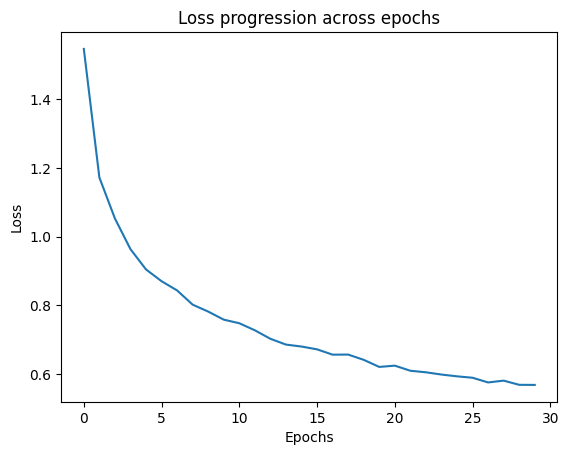

In [ ]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
)

plot_loss(train_losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)


One of the benefits of Batch Norm is that it allows us to use higher learning rates. Adapt the code above to do so. Does the model learn faster? [0.25 points]


Epoch 0: Train Loss=2.0091
Epoch 1: Train Loss=1.3095
Epoch 2: Train Loss=1.1518
Epoch 3: Train Loss=1.0629
Epoch 4: Train Loss=0.9923
Epoch 5: Train Loss=0.9596
Epoch 6: Train Loss=0.9299
Epoch 7: Train Loss=0.8913
Epoch 8: Train Loss=0.8657
Epoch 9: Train Loss=0.8447
Epoch 10: Train Loss=0.8165
Epoch 11: Train Loss=0.8026
Epoch 12: Train Loss=0.7833
Epoch 13: Train Loss=0.7664
Epoch 14: Train Loss=0.7532
Epoch 15: Train Loss=0.7465
Epoch 16: Train Loss=0.7282
Epoch 17: Train Loss=0.7182
Epoch 18: Train Loss=0.7039
Epoch 19: Train Loss=0.6885
Epoch 20: Train Loss=0.6794
Epoch 21: Train Loss=0.6832
Epoch 22: Train Loss=0.6731
Epoch 23: Train Loss=0.6640
Epoch 24: Train Loss=0.6559
Epoch 25: Train Loss=0.6472
Epoch 26: Train Loss=0.6388
Epoch 27: Train Loss=0.6343
Epoch 28: Train Loss=0.6262
Epoch 29: Train Loss=0.6236
Test set: Avg. loss: 1.1476, Accuracy: 6522/10000 (65%)


(1.147567724609375, tensor(65.2200, device='mps:0'))

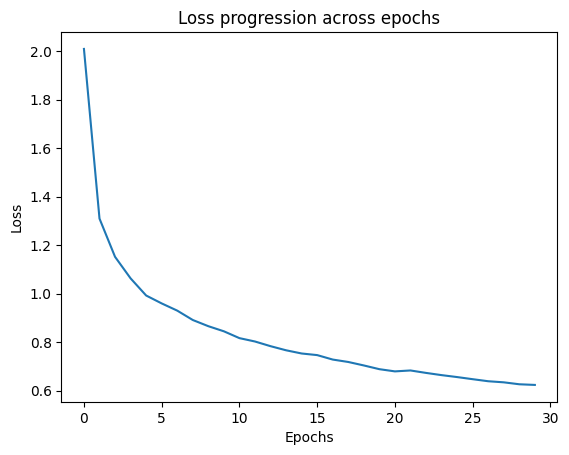

In [ ]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.05, momentum=0.9)

train_losses, valid_losses, valid_accs =fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
    )

plot_loss(train_losses)


predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)

## Learning rate scheduler [0.5 points]

We have just seen that batch normalization allows, in this case, for a quicker improvement with a higher learning rate. Still, the loss plateaus quickly and me start seeing minimal improvement. This is often due to the optimization algorithm overshooting the gradient descent.

Can we reduce the step size on the go? Yes! :smiley: This is what learning schedulers are for. The idea is simple: instead of a constant learning rate, we reduce it based on some conditions, or after a certain amount of steps.

Two common schedulers are [`MultiStepLR`][MultiStepLR] and [`ReduceLROnPlateau`][ReduceLROnPlateau]. The first one, simply multiplies our learning rate `lr` by a constant factor $\gamma < 1$ after some predefined number of steps. For instance, if the initial learning rate is `lr=1`, and we set $\gamma=0.5$ for "milestones" of 20 and 50, then the optimizer is going to use `lr=1` for the first 20 epochs, then `lr=0.5` for the subsequent 30, and finally `lr=0.25` for all the remaining ones.

`ReduceLROnPlateau` tracks a given metric, e.g. validation loss or accuracy, and reduces the learning rate if no improvement is seen after a predefined number of steps, called "patience".

[MultiStepLR]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
[ReduceLROnPlateau]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In the following cell, augment the `fit` function from previous weeks (in `training_utils.py`) to accept a scheduler argument and use it while training

In [18]:
from training_utils import train_epoch

def fit_scheduler(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None
):
    losses = []
    # YOUR CODE GOES HERE
    return losses

In [19]:
def fit_scheduler(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None
):
    """
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    """

    # keep track of the losses in order to visualize them later
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

        if scheduler is not None:
            scheduler.step()

    return losses


Now train again the batch-norm-cnn, using the `MultiStepLR` scheduler.

Epoch 0: Loss=1.906186935852985
Epoch 1: Loss=1.2416124879097452
Epoch 2: Loss=1.119632533618382
Epoch 3: Loss=1.042726412111399
Epoch 4: Loss=0.9775657094254786
Epoch 5: Loss=0.9225336069963417
Epoch 6: Loss=0.8900119333851094
Epoch 7: Loss=0.8800540882713941
Epoch 8: Loss=0.8381019794211095
Epoch 9: Loss=0.8117915635206261
Epoch 10: Loss=0.7926568851179007
Epoch 11: Loss=0.7758718704690739
Epoch 12: Loss=0.7569287236855955
Epoch 13: Loss=0.7419218603445559
Epoch 14: Loss=0.7342556058144083
Epoch 15: Loss=0.7153296799075847
Epoch 16: Loss=0.7048193532593396
Epoch 17: Loss=0.6981729439326695
Epoch 18: Loss=0.6807170157529869
Epoch 19: Loss=0.6784237623214722
Epoch 20: Loss=0.6695322844446921
Epoch 21: Loss=0.653496537889753
Epoch 22: Loss=0.6589433356207244
Epoch 23: Loss=0.643447394273719
Epoch 24: Loss=0.6455208282081448
Epoch 25: Loss=0.5758789972383149
Epoch 26: Loss=0.5569003504149768
Epoch 27: Loss=0.5525949341910226
Epoch 28: Loss=0.5504457500516152
Epoch 29: Loss=0.547953137329

(0.9538209716796875, tensor(69.4800, device='mps:0'))

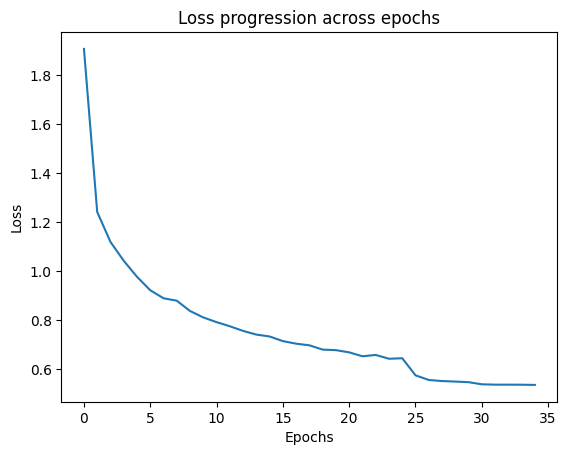

In [ ]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.05, momentum=0.9)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[25, 30],
    gamma=0.1,
)


losses =   fit_scheduler(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE,
        scheduler=scheduler,
)

plot_loss(losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)


## Residual connections [1 point]

As neural networks go deeper, they are able to construct complex representations and yield superior performance. However, we cannot simply stack as many layers as we want to increase the depth.

![caption](media/resnet-horizontal.png)

This is due to the **vanishing gradient** problem. Specifically, backpropagating the gradient to earlier layers involves repeated multiplication (with small values) rendering the gradient extremely small. This effectively means that as we go deeper, performance gets saturated. Instead of improved performance we even have degradation!

How can we reconcile this tradeoff? On the one hand, we want to increase depth but on the other hand this hurts convergence.

Enter **skip connections** [3]! The network of the previous figure now becomes the following:

![caption](media/resnet-horizontal.png)

Now, let's think why these skip connections work. First, they allow the gradient to flow via this shortcut connection, which helps mitigate the problem of vanishing gradient. Second, they allow the model to learn the identity function. In other words, this ensures that the higher layer will perform at least as good as the lower layer.

---
[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Jun. 2016, pp. 770–778. doi: 10.1109/CVPR.2016.90.



First, we build the network of the first image, i.e. with no skip connections. The Resnet depicted above is characterized by an interesting pattern. It consists of "super-blocks" (see the different colors) and each one consists of two blocks that start after one residual connection and finish just before one. Notice that each color is associated with a different number, i.e. 64, 128, 256, 512.

We will build a `nn.Module` for each block and repeat it to create the super-blocks and by extension the whole architecture.

The ResNet depicted above is meant to be used for `ImageNet`, a more complex dataset compared to `CIFAR10`. For computational considerations, we amend our implementation and make a simpler version.

In [20]:
class WrongBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_planes,
            out_channels = planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



Epoch 0: Train Loss=2.2757
Epoch 1: Train Loss=1.8261
Epoch 2: Train Loss=1.6706
Epoch 3: Train Loss=1.5200
Epoch 4: Train Loss=1.3539
Epoch 5: Train Loss=1.2175
Epoch 6: Train Loss=1.0893
Epoch 7: Train Loss=0.9791
Epoch 8: Train Loss=0.9043
Epoch 9: Train Loss=0.8190
Epoch 10: Train Loss=0.7457
Epoch 11: Train Loss=0.6791
Epoch 12: Train Loss=0.6213
Epoch 13: Train Loss=0.5584
Epoch 14: Train Loss=0.5016
Epoch 15: Train Loss=0.4498
Epoch 16: Train Loss=0.4115
Epoch 17: Train Loss=0.3664
Epoch 18: Train Loss=0.3250
Epoch 19: Train Loss=0.2968
Epoch 20: Train Loss=0.2633
Epoch 21: Train Loss=0.2287
Epoch 22: Train Loss=0.2021
Epoch 23: Train Loss=0.1720
Epoch 24: Train Loss=0.1574
Epoch 25: Train Loss=0.1304
Epoch 26: Train Loss=0.1120
Epoch 27: Train Loss=0.1066
Epoch 28: Train Loss=0.0982
Epoch 29: Train Loss=0.0852
Epoch 30: Train Loss=0.0671
Epoch 31: Train Loss=0.0647
Epoch 32: Train Loss=0.0661
Epoch 33: Train Loss=0.0561
Epoch 34: Train Loss=0.0506
Test set: Avg. loss: 0.9151, A

(0.9150595825195312, tensor(82.1100, device='cuda:0'))

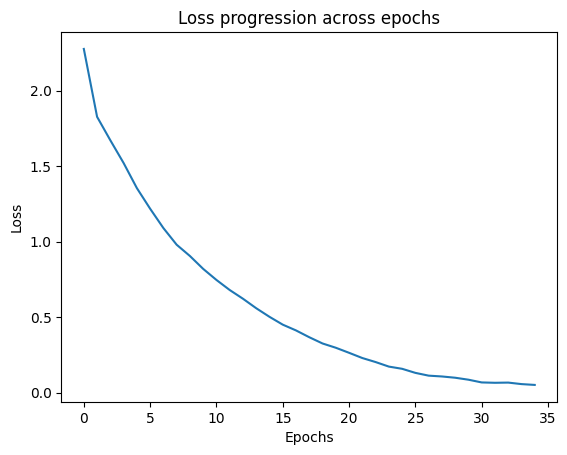

In [23]:
# initialize the model
model = ResNet(block=WrongBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE
    )

plot_loss(train_losses)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


How many layers does the above model have?

Now, we add skip connections. Notice that sometimes the skip connection cannot be simply an identity function, since the dimensions will not match. Identify the condition when this is necessary. In that case, the shortcut function should be a convolution followed by BatchNorm.

Fill the code below!

In [24]:

class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


Epoch 0: Train Loss=2.2203
Epoch 1: Train Loss=1.6534
Epoch 2: Train Loss=1.4300
Epoch 3: Train Loss=1.2655
Epoch 4: Train Loss=1.1340
Epoch 5: Train Loss=0.9828
Epoch 6: Train Loss=0.8640
Epoch 7: Train Loss=0.7809
Epoch 8: Train Loss=0.6917
Epoch 9: Train Loss=0.5998
Epoch 10: Train Loss=0.5186
Epoch 11: Train Loss=0.4332
Epoch 12: Train Loss=0.3424
Epoch 13: Train Loss=0.2811
Epoch 14: Train Loss=0.2110
Epoch 15: Train Loss=0.1458
Epoch 16: Train Loss=0.1103
Epoch 17: Train Loss=0.0728
Epoch 18: Train Loss=0.0505
Epoch 19: Train Loss=0.0419
Epoch 20: Train Loss=0.0514
Epoch 21: Train Loss=0.0632
Epoch 22: Train Loss=0.0543
Epoch 23: Train Loss=0.0380
Epoch 24: Train Loss=0.0214
Epoch 25: Train Loss=0.0144
Epoch 26: Train Loss=0.0137
Epoch 27: Train Loss=0.0121
Epoch 28: Train Loss=0.0116
Epoch 29: Train Loss=0.0205
Epoch 30: Train Loss=0.0368
Epoch 31: Train Loss=0.0486
Epoch 32: Train Loss=0.0444
Epoch 33: Train Loss=0.0244
Epoch 34: Train Loss=0.0141
Test set: Avg. loss: 1.3819, A

(1.3818841186523438, tensor(78.3700, device='cuda:0'))

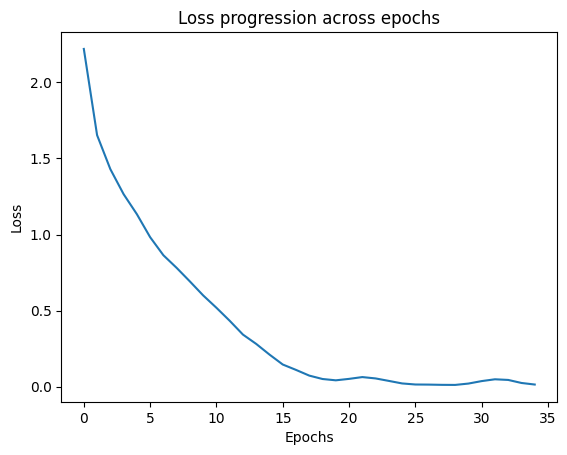

In [25]:
# initialize the model
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE
    )
plot_loss( train_losses )

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


**Question:** It looks like the model without the residual connections performs better (3-4%), but on a closer examination of the training curves the residual model achieves lower loss much faster and then plateaus. You might try to add a scheduler to boost the performance!